In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [122]:
experiment = "Unmutated"

### Standardize Feature Sensitivity Analysis


In [123]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def local_sensitivity_analysis(df, feature: str, std_factor: int, use_feature_std: int):
    original_data = df.copy()
    original_color = "blue"
    perturbed_color = "orange"
    # Calculate mean and standard deviation
    feature_stddev: float = np.std(df[feature])
    feature_mean: float = np.mean(df[feature])

    x_min = np.min(df[feature]) - feature_stddev
    x_max = np.max(df[feature]) + feature_stddev
    
    print(rf"{feature.title()} has std = {feature_stddev}...")
    print(rf"{feature.title()} has mean = {feature_mean}...")
    
    # Choosing std to create Gaussian curve to produce noise
    if use_feature_std == 1:
        std = feature_stddev * std_factor
    else: 
        std = std_factor


    ### Adding Noise
    print(f"Using std = {std} to create Gaussian noise...")
    noise = np.random.normal(0, std, df[feature].shape)
    print(f"Adding {df[feature].shape} Gaussian noise samples from {np.min(noise)} to {np.max(noise)}...")
    df[feature] = df[feature] + noise
    
    if use_feature_std ==1: 
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))  # Changed to 2 subplots for distribution plots

        ax[1].hist(original_data[feature], bins=30, alpha=0.25, color=original_color, label = "Original")
        ax[1].hist(df[feature], bins=30, alpha=0.25, color=perturbed_color, label = "Perturbed")
        ax[1].set_title(f"{feature.title()} Distribution")
        ax[1].set_xlabel('Value')
        ax[1].set_ylabel('Frequency')
        ax[1].set_xlim([x_min, x_max])
        ax[1].legend(loc="best")

        # Plot: Noise distribution plot
        ax[0].axvline(x=std, linestyle="--", color='lightgrey', label=rf"+$\sigma$")
        ax[0].axvline(x=-std, linestyle="--", color='lightgrey', label=rf"-$\sigma$")
        ax[0].hist(noise, bins=30, alpha=0.75, color='skyblue', edgecolor="black")
        ax[0].set_title(rf"Noise Distribution with $\sigma$={std:.2f}")
        ax[0].set_xlabel('Noise Value')
        ax[0].set_ylabel('Frequency')
        plt.legend()
        plt.show()
    else:
        plt.hist(original_data[feature], bins=30, alpha=0.25, color=original_color, label = "Original")
        plt.hist(df[feature], bins=30, alpha=0.25, color=perturbed_color, label = "Perturbed")
        plt.title(f"{feature.title()} Distribution")
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.xlim([x_min, x_max])
        plt.legend(loc="best")

    #Plot: Feature before and after perturbation
    example_spore_perturbed = df[df["SPORE_ID"] == 1]
    example_spore_original = original_data[original_data["SPORE_ID"]==1]
    germination_status = example_spore_original["GERMINATION"].to_list()
    example_germination = germination_status.index(1)    
    plt.figure(figsize=(6, 4))

    sns.lineplot(x=range(0, len(germination_status)), y=example_spore_original[feature], color=original_color, label="Original")
    sns.lineplot(x=range(0, len(germination_status)), y=example_spore_perturbed[feature], color=perturbed_color, label="Perturbed", alpha = 0.5)
    
    plt.axvline(example_germination, color='lightgrey', linestyle='--', label="Germination")
    plt.xlabel("Frame")
    plt.ylabel(feature.title())
    plt.title(rf"{feature.title()} of Spore 1 with {std_factor}$\sigma_{feature[0]}$")
    plt.legend(loc="best")
    plt.show()

    delta_x = np.mean(np.abs(original_data[feature] - df[feature]))

    return df, delta_x, 1

In [124]:
# df_test = pd.read_csv("/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data_V2.csv")
# sensitivity_feature = "PERIMETER"
# feature_std: int = 1  # 1 to use std of feature, 0 for plain std 
# scale_factor = 0.1  # Scale for std
# sensitivity_gauss_performed = 0
# df_test, delta_x, sensitivity_gauss_performed = local_sensitivity_analysis(df_test, sensitivity_feature, scale_factor, feature_std)

### Feature Sensitivity Analysis

In [125]:
csv = f"/Users/alexandranava/Desktop/Spores/GerminationPrediction/Model_Analysis/{experiment.lower()}_sensitivity_featurestd.csv"

df = pd.read_csv(csv)
print(df.columns)
if experiment == "unmutated":
  true_model_accuracy = 94.4444
if experiment == "KtrC":
  true_model_accuracy == 99.0654

df["Change Accuracy"] = true_model_accuracy - df["Accuracy"]
df["SI"] = df["Change Accuracy"]/df["Delta x"]

Index(['Feature', 'Accuracy', 'STD', 'Delta x'], dtype='object')


[1.  0.1 0.5]


Text(0.5, 1.0, 'Unmutated Local Sensitivity Analysis')

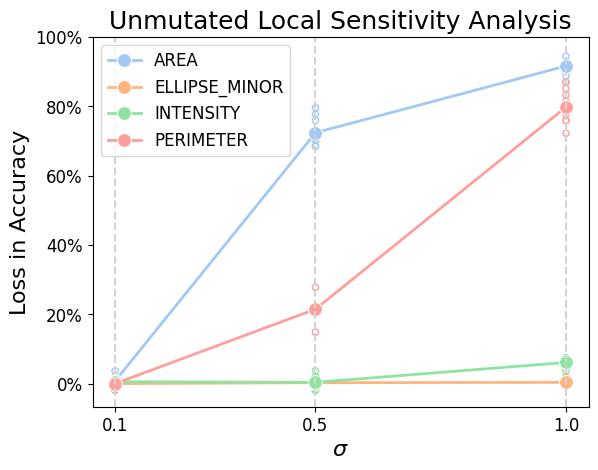

In [129]:
sigmas = df["STD"].unique()
print(sigmas)


feature_colors = sns.color_palette("pastel", (len(df["Feature"].unique())))
mean_changeaccuracy_df = df.groupby(["Feature", "STD"])["Change Accuracy"].mean().reset_index()
sns.lineplot(data=mean_changeaccuracy_df, x="STD", y="Change Accuracy", hue="Feature", marker="o", palette="pastel", markersize = 10, linewidth = 2)

color_index = 0
for feature, group in df.groupby(["Feature"]):
  plt.scatter(group["STD"], group["Change Accuracy"], color=feature_colors[color_index], facecolors = "none", s= 20)
  color_index += 1

#vertical line at each std 
for sigma in list(sigmas):
  plt.axvline(sigma, color = "lightgrey", linestyle = "--")
plt.legend(loc = "best")

#xaxis formatting
plt.xlabel(r"$\sigma$", fontsize = 16)
plt.xticks(sigmas, fontsize = 12)
#yaxis formatting
plt.ylabel(r"Loss in Accuracy", fontsize = 16)
plt.yticks([0, 20, 40, 60, 80, 100], ["0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 12)

plt.legend(fontsize = 12)
plt.title(f"{experiment} Local Sensitivity Analysis", fontsize = 18)

### Temporal Sensitivity Analysis 

In [127]:
tsa_path_relative = f"/Users/alexandranava/Desktop/Spores/GerminationPrediction/Model_Analysis/{experiment.lower()}_temporal_sensitivity_relative.csv"
tsa_relative_df = pd.read_csv(tsa_path_relative)


10    [-10, 0]
18    [-10, 0]
17    [-10, 0]
16    [-10, 0]
15    [-10, 0]
14    [-10, 0]
13    [-10, 0]
12    [-10, 0]
11    [-10, 0]
19    [-10, 0]
20     [-3, 0]
8      [0, 10]
7      [0, 10]
6      [0, 10]
5      [0, 10]
4      [0, 10]
3      [0, 10]
2      [0, 10]
1      [0, 10]
9      [0, 10]
0      [0, 10]
Name: Timerange, dtype: object


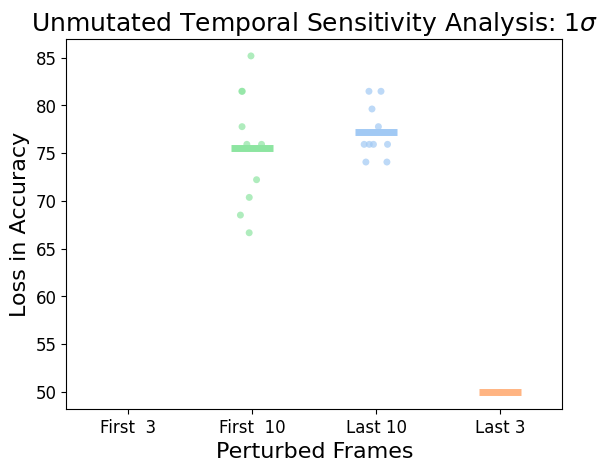

In [128]:
def plot_temporal_sensitivity_accuracy(df):

    # Sort the DataFrame by "TimeRange"
    df = df.sort_values("Timerange")
    print(df["Timerange"])

    # Calculate the loss in accuracy
    df["Loss in Accuracy"] = true_model_accuracy - df["Accuracy"]

    range_order = ['[-3, 0]','[-10, 0]', '[0, 10]', '[0, 3]']
    sns.stripplot(x = "Timerange", y = "Loss in Accuracy", data = df, label="Accuracy Loss", alpha = .7, hue = "Timerange", palette = "pastel", order = range_order)
    sns.pointplot(x = "Timerange", y = "Loss in Accuracy", data = df, errorbar = None, linestyle = "none", marker = "_", hue = "Timerange", markeredgewidth = 5, markersize = 30, palette = "pastel", order = range_order)

    x_labels = []
    for time_range in range_order:
        time_range = time_range.replace("[", "")
        time_range = time_range.replace("]", "")
        time_range = time_range.split(",")

        if int(time_range[0]) == 0:
            x_labels.append(f"First {time_range[1]}")
        if int(time_range[1]) == 0:
            time_range[0] = time_range[0].replace("-", "")
            x_labels.append(f"Last {time_range[0]}")
        
    plt.xticks(range_order, x_labels, fontsize = 12)
    plt.yticks(fontsize = 12)
    # Label the axes
    plt.xlabel("Perturbed Frames", fontsize = 16)
    plt.ylabel("Loss in Accuracy", fontsize = 16)
    plt.gca().invert_xaxis()
    plt.title(rf"{experiment} Temporal Sensitivity Analysis: {df['Relative STD Scaler'].iloc[0]}$\sigma$", fontsize = 18)
    
plot_temporal_sensitivity_accuracy(tsa_relative_df)

  